In [ ]:
# 참고 : https://github.com/kairess/mask-detection

In [ ]:
# 내 구글 드라이브 연동
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Colab에서 GitHub 에 있는 데이터 가져오기
# model 다운로드 URL : https://github.com/kairess/mask-detection
# Clone Web URL 를 복사해 옵니다.

!git clone https://github.com/kairess/mask-detection.git

Cloning into 'mask-detection'...
remote: Enumerating objects: 33, done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 33
Unpacking objects: 100% (33/33), done.


In [ ]:
# 파일 복사
!cp -r mask-detection/models gdrive/My\ Drive/CV2/Face\ Mask\ Detection/
!cp -r mask-detection/imgs gdrive/My\ Drive/CV2/Face\ Mask\ Detection/
print('files copy complete!!')

files copy complete!!


In [ ]:
# 필요한 패키지와 모듈을 불러옴
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import load_model
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import os

In [ ]:
# DNN으로 학습한 모델(caffemodel)을 사용
model_name = "gdrive/My Drive/CV2/Face Mask Detection/models/res10_300x300_ssd_iter_140000.caffemodel"
# model Architecture 의 설계도 파일
prototxt_name = "gdrive/My Drive/CV2/Face Mask Detection/models/deploy.prototxt"
 
# Mask Detection 모델을 사용
masknet = load_model('gdrive/My Drive/CV2/Face Mask Detection/models/mask_detector.model')
 
min_confidence = 0.4  # detection 으로 인정할 최소 확률(신뢰도)
file_name = "gdrive/My Drive/CV2/Face Mask Detection/imgs/01.jpg"   # 원본 이미지

In [ ]:
def detectAndDisplay(frame):
    # frame_width 에 맞춰 image resize
    (height, width) = frame.shape[:2]
    ratio = frame_width / width
    dimension = (frame_width, int(height * ratio))
    frame = cv2.resize(frame, dimension, interpolation = cv2.INTER_AREA)
 
    # caffemodel의 weight 값과 모델 네트워크 구성을 불러와서 모델을 정의한다.
    model = cv2.dnn.readNetFromCaffe(prototxt_name, model_name)
 
    # 이미지를 300x300 으로 size를 조정하고 blob 를 만든다.
    blob = cv2.dnn.blobFromImage(cv2.resize(frame, (300, 300)), 1.0,
            (300, 300), (104.0, 177.0, 123.0))
 
    # blob을 모델에 넣는다
    model.setInput(blob)
    # detection을 수행한다.
    detections = model.forward()
 
    # detections 한 수만큼 루프가 돈다.
    for i in range(0, detections.shape[2]):
           
            confidence = detections[0, 0, i, 2]  # confidence 는 detection한 확률을 나타냄
 
            # min_confidence 보다 큰 경우에만 detection 으로 인정함
            if confidence > min_confidence:
                    # detection 된 영역을 boxing
                    # 상대적 좌표 * np.array([width, height, width, height]) 절대적인 boxing 좌표을 구해낸다 
                    # box = detections[0, 0, i, 3:7] * np.array([width, height, width, height])
                    box = detections[0, 0, i, 3:7] * np.array([frame_width, int(height * ratio), frame_width, int(height * ratio)])
                    (startX, startY, endX, endY) = box.astype("int")
                    print(confidence, startX, startY, endX, endY)
 
                    faceROI = img[startY:endY, startX:endX]
 
                    face_input = cv2.resize(faceROI, dsize=(224, 224))
                    face_input = cv2.cvtColor(face_input, cv2.COLOR_BGR2RGB)
                    face_input = preprocess_input(face_input)
                    face_input = np.expand_dims(face_input, axis=0)  # 앞에 차원을 하나 늘려줌
 
                    # Face mask detection        
                    mask, nomask = masknet.predict(face_input).squeeze()   # squeeze() 는 차원 중 사이즈가 1인 것을 찾아 제거한다.
 
                    if mask > nomask:
                        color = (0, 255, 0)
                        label = 'Mask %d%%' % (mask * 100)
                    else:
                        color = (0, 0, 255)
                        label = 'No Mask %d%%' % (nomask * 100)
 
                    y = startY - 10 if startY - 10 > 10 else startY + 10
                    cv2.rectangle(frame, (startX, startY), (endX, endY),
                            (0, 255, 0), 2)
                    cv2.putText(frame, label, (startX, y),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
 
    # show the output image
    print("#### Face detection(DNN_CAFFE) ####")
    # 이미지를 Display 한다.
    cv2_imshow(frame)

width: 620 pixels
height: 349 pixels
channels: 3
#### Original Image ####


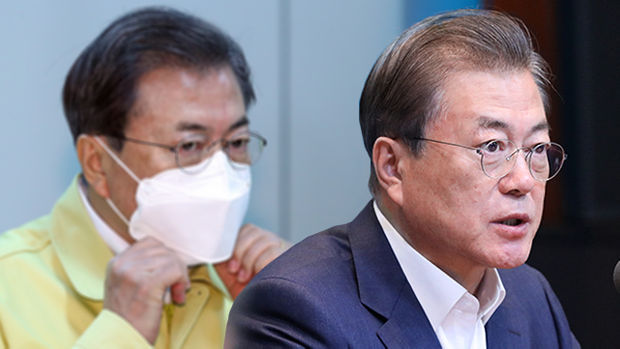

In [ ]:
# detection 하기 전에 원본 이미지를 Display 한다.
img = cv2.imread(file_name)
print("width: {} pixels".format(img.shape[1]))
print("height: {} pixels".format(img.shape[0]))
print("channels: {}".format(img.shape[2]))
 
(height, width) = img.shape[:2]
 
print("#### Original Image ####")
cv2_imshow(img)

0.99986804 334 51 444 213
0.853429 99 47 207 212
#### Face detection(DNN_CAFFE) ####


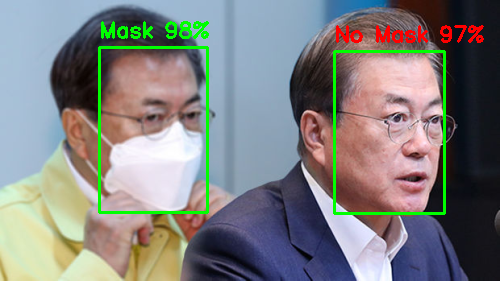

In [ ]:
# 이미지 width size 지정
frame_width = 500
 
# face detection 하고 display 하는 함수 호출
detectAndDisplay(img)